In [6]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

In [7]:
SIZE = 28
meta = pd.read_csv('metadata.csv', delimiter=',')
data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))

folder = "./baseline-IDG-lr0.001-epoch50-batchsize32"
labels = list(meta.dx.unique())

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(data, to_categorical(label_encoder.fit_transform(meta.dx)), test_size=0.2, random_state=42069)



In [9]:
X_train = np.array(X_train).reshape(-1, SIZE, SIZE,1)
X_test = np.array(X_test).reshape(-1, SIZE, SIZE,1)

# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.25
)

datagen.fit(X_train)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='leaky_relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'),
                    steps_per_epoch=(len(X_train) * 0.75) // 32,
                    epochs=20,
                    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
                    validation_steps=(len(X_train) * 0.25) // 32)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 7)                 18935     
                                                                 
Total params: 19,095
Trainable params: 19,095
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-03-15 20:36:14.429595: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-15 20:36:14.429621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: x1-6226
2023-03-15 20:36:14.429626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: x1-6226
2023-03-15 20:36:14.429706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-03-15 20:36:14.429730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-03-15 20:36:14.429740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-03-15 20:36:14.430052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Li

187/187 [==============================] - 3s 13ms/step - loss: 8.7006 - accuracy: 0.5351 - val_loss: 1.9523 - val_accuracy: 0.6089
Epoch 2/20
187/187 [==============================] - 2s 13ms/step - loss: 1.8693 - accuracy: 0.5954 - val_loss: 1.4521 - val_accuracy: 0.6124
Epoch 3/20
187/187 [==============================] - 2s 12ms/step - loss: 1.4019 - accuracy: 0.6256 - val_loss: 1.3220 - val_accuracy: 0.6376
Epoch 4/20
187/187 [==============================] - 2s 12ms/step - loss: 1.3372 - accuracy: 0.6309 - val_loss: 1.2268 - val_accuracy: 0.6371
Epoch 5/20
187/187 [==============================] - 2s 12ms/step - loss: 1.2574 - accuracy: 0.6440 - val_loss: 1.2600 - val_accuracy: 0.6552
Epoch 6/20
187/187 [==============================] - 2s 12ms/step - loss: 1.2063 - accuracy: 0.6436 - val_loss: 1.2101 - val_accuracy: 0.6094
Epoch 7/20
187/187 [==============================] - 2s 12ms/step - loss: 1.1931 - accuracy: 0.6562 - val_loss: 1.1477 - val_accuracy: 0.6522
Epoch 8/20

In [11]:
def plot_model_history(model_history):
    print(model_history.history.keys)
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])//10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [12]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

63/63 [==============================] - 0s 1ms/step
(2003, 7)
63/63 [==============================] - 0s 2ms/step - loss: 1.1760 - accuracy: 0.6390
Test: accuracy = 0.639041  ;  loss = 1.176040


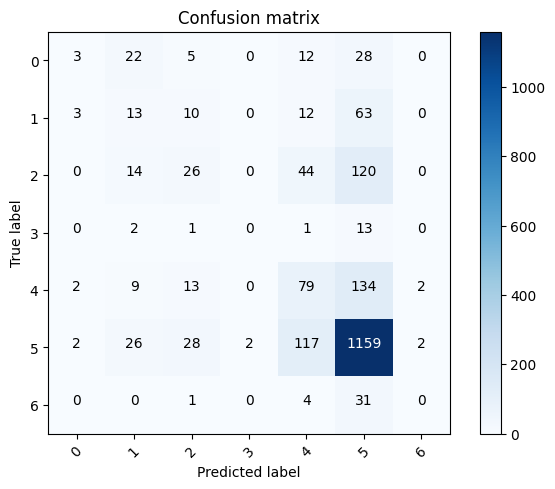

In [13]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
print(Y_pred.shape)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

loss_t, accuracy_t = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_t, loss_t))

In [14]:
from sklearn.metrics import classification_report

model.save(folder)

with open(folder + "/scores.txt", "w") as f:
    f.write(classification_report(Y_true, Y_pred.argmax(axis=1), target_names=labels))


INFO:tensorflow:Assets written to: ./baseline-IDG-lr0.001-epoch50-batchsize32/assets


INFO:tensorflow:Assets written to: ./baseline-IDG-lr0.001-epoch50-batchsize32/assets
